MNIST classification
====================

Simple classification of MNIST digits.

## Import packages

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, UpSampling2D, Conv2D, LeakyReLU, Flatten, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle, randint

## Check wether we use GPU or not

In [3]:
# print version and make sure we're using GPU
print("Tensorflow version", tf.__version__)
if tf.test.is_gpu_available():
    print("Congratulations, you're running on GPU!")
else:
    print("We couldn't find your GPU")

Tensorflow version 2.0.0-dev20190324
We couldn't find your GPU


## Load dataset

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(type(x_train))

<class 'numpy.ndarray'>


In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_train[0].shape)
print(x_train[0])


(60000, 28, 28)
(60000,)
(28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        

Let's show some numbers to see what we can find in the dataset.

Text(0.5, 1.0, 'This is a 7')

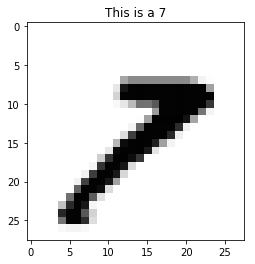

In [6]:
image_number = randint(0, y_train.shape[0] - 1)
plt.imshow(x_train[image_number,:,:], cmap="Greys")
plt.title("This is a {}".format(y_train[image_number]))

## Define the network

In [26]:
def build_mnist_classifier(input_shape=(28, 28)):
    img = Input(shape=input_shape, dtype="float32")
    input_shape_with_channels = (*input_shape, 1)
    reshapedImg = Reshape(input_shape_with_channels)(img)
#     x = tf.expand_dims(img, len(img.shape))
#     print(x.shape)
    
    jsInput = Input(shape=input_shape_with_channels, dtype="float32")
    x = jsInput
    
    # conv layers
    x = Conv2D(16, (3, 3), padding="valid", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="valid", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="valid", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="valid", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="valid", activation="relu")(x)
    
    # dense layers
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dense(10)(x)
    out = Softmax()(x)
    
    # build model
    modeljs = Model(inputs=[jsInput], outputs=[out])
    
    out = modeljs(reshapedImg)
    model = Model(inputs=[img], outputs=[out])
    
    return model, modeljs

model, modeljs = build_mnist_classifier()

In [29]:
type(model)
model.__dict__.keys()
model.layers
for layer in model.layers:
    print(layer.name)
print("_____-")
for layer in modeljs.layers:
    print(layer.name)

input_11
reshape_10
model_8
_____-
input_12
conv2d_30
conv2d_31
conv2d_32
conv2d_33
conv2d_34
flatten_6
dense_24
dense_25
dense_26
dense_27
softmax_6


In [30]:
def compile_model(model):
    optimizer = Adam()
    
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [32]:
model, modeljs = build_mnist_classifier()
model = compile_model(model)

In [33]:
model.fit(x_train, y_train, epochs=1)

60000/60000 [==============================] - 91s 2ms/sample - loss: 0.1251 - accuracy: 0.9621


In [34]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 337us/sample - loss: 0.0398 - accuracy: 0.9865


[0.0398292028212687, 0.9865]

## Save model

In [36]:
model.summary()
modeljs.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_12 (Model)             (None, 10)                1370442   
Total params: 1,370,442
Trainable params: 1,370,442
Non-trainable params: 0
_________________________________________________________________
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 26, 26, 16)        160       
______________________________

In [16]:
model.save('hola.h5')

In [17]:
tf.keras.models.save_model(model, "mnist_model.h5", include_optimizer=False)

# Save model to be used from the browser

You should be able to first save the model to disk

```python
model.save('hola.h5')
tf.keras.models.save_model(model, "mnist_model.h5", include_optimizer=False)
```

Later you have to compile these models to the format of tensorflowjs

```bash
tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model model.h5 output_dir/
```

However I couldn't make it work either with `TF1.13` nor `TF2.0-alpha`.
So I tried installing `tensorflowjs` and saving directly the js format.
That worked, see below.

In [40]:
import tensorflowjs as tfjs

In [42]:
tfjs.converters.save_keras_model(model, "js/")